In [108]:
import os, cv2
import tensorflow as tf
import matplotlib.pyplot as plt, numpy as np, pandas as pd
from tensorflow import keras

from centernet import CenterNet, decode

from data import VOCDataset
from losses import centernet_loss

In [70]:
input_shape = (512, 512)
backbone = 'resnet50'

epochs = 1
batch_size = 2
buffer_size = batch_size * 5
lr = 1e-2
freeze = True
finetune = True or freeze

data_path = "..\\..\\Centernet\\VOC2007"
train_file = "..\\..\\Centernet\\VOC2007\\ImageSets\\ceph\\train.txt"
val_file = "..\\..\\Centernet\\VOC2007\\ImageSets\\ceph\\val.txt"
test_file = "..\\..\\Centernet\\VOC2007\\ImageSets\\ceph\\test.txt"

val_dataset_raw = VOCDataset(data_path, input_shape, val_file,
                             batch_size, False)
val_dataset = val_dataset_raw.load_dataset()

########
test_dataset_raw = VOCDataset(data_path, input_shape, test_file,
                             batch_size, False)
test_dataset = test_dataset_raw.load_dataset()
########

vis_dataset_raw = VOCDataset(data_path, input_shape, train_file, 1, False)
vis_dataset = vis_dataset_raw.load_dataset().repeat()

steps_per_epoch = len(train_dataset_raw) // batch_size

loading the context of data_file ...: 50it [00:00, 50123.14it/s]
loading the context of data_file ...: 50it [00:00, 50111.16it/s]
loading the context of data_file ...: 550it [00:00, 551222.75it/s]


In [3]:
ckpt_path = './logs/test/20220525-180744/ckpt.h5'

model = CenterNet(train_dataset_raw.class_names,
                      backbone_weights='imagenet',
                      freeze=freeze,
                      finetune=finetune)

In [4]:
model.build(input_shape=(1, 512, 512, 3))
model.load_weights(ckpt_path)

In [5]:
hm_pred, wh_pred, reg_pred = model.predict(val_dataset)

In [85]:
detections_pred = decode(hm_pred, wh_pred, reg_pred, 1000)

In [86]:
# topk_x1, topk_y1, topk_x2, topk_y2, scores, class_ids

detections_pred.shape

TensorShape([50, 1000, 6])

In [87]:
detections_pred[0][0]

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([6.5577545e+01, 4.7899761e+01, 8.5458084e+01, 6.7100067e+01,
       7.9445302e-02, 1.0000000e+00], dtype=float32)>

In [88]:
t = detections_pred[0]
print(t.shape)

(1000, 6)


In [90]:
for topk_x1, topk_y1, topk_x2, topk_y2, scores, class_ids in t:
    if(class_ids==2):
        print(class_ids, scores)

tf.Tensor(2.0, shape=(), dtype=float32) tf.Tensor(0.042385817, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32) tf.Tensor(0.0403831, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32) tf.Tensor(0.039646238, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32) tf.Tensor(0.03938514, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32) tf.Tensor(0.0389356, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32) tf.Tensor(0.038670003, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32) tf.Tensor(0.038668245, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32) tf.Tensor(0.038253367, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32) tf.Tensor(0.037692785, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32) tf.Tensor(0.03752634, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32) tf.Tensor(0.037512094, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32

In [64]:
topk_x1, topk_y1, topk_x2, topk_y2, scores, class_ids = t[0]

In [66]:
t[50]

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([6.9865395e+01, 7.0042084e+01, 9.3170235e+01, 9.2957748e+01,
       6.3330263e-02, 1.0000000e+00], dtype=float32)>

In [47]:
t_1 = np.array(t[0])

In [48]:
t_1.shape

(6,)

In [82]:
val_dataset_raw[49][1].shape

(3, 4)

In [35]:
# image, boxes, cls_ids, hms, whs, regs, reg_masks, indices
# [i][1] : boxes

val_dataset_raw[0][1][0]

array([106.5 ,  24.75, 122.5 ,  40.75], dtype=float32)

In [83]:
pnt_x = int((t_1[0] + t_1[2])/2)
pnt_y = int((t_1[1] + t_1[3])/2)

xmin,ymin,xmax,ymax = val_dataset_raw[0][1][1]
gt_x = int((xmin + xmax)/2)
gt_y = int((ymin + ymax)/2)

print(pnt_x, pnt_y, gt_x, gt_y)

75 57 80 61


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


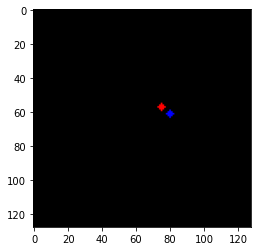

In [84]:
zeros = np.zeros((128, 128, 3))

cv2.circle(zeros, (pnt_x,pnt_y), 2, (255, 0, 0), -1)
cv2.circle(zeros, (gt_x, gt_y), 2, (0, 0, 255), -1)

plt.imshow(zeros)

---

In [93]:
val_dataset_raw[0][1][0]

array([106.5 ,  24.75, 122.5 ,  40.75], dtype=float32)

In [91]:
def point_mse(arr, gt):
    pnt_x = int((arr[0] + arr[2])/2)
    pnt_y = int((arr[1] + arr[3])/2)

    xmin,ymin,xmax,ymax = gt

    gt_x = int((xmin + xmax)/2)
    gt_y = int((ymin + ymax)/2)

    return np.sqrt((gt_y-pnt_y)**2 + (gt_x-pnt_x)**2)

In [117]:
t = detections_pred

mse_result = []


for i in range(50):
    #topk_x1, topk_y1, topk_x2, topk_y2, scores, class_ids
    Glabella = []
    point_R3 = []
    Nasion = []


    for topk_x1, topk_y1, topk_x2, topk_y2, scores, class_ids in t[i]:

        if(class_ids==0):
            Glabella.append([topk_x1, topk_y1, topk_x2, topk_y2])

        elif(class_ids==1):
            point_R3.append([topk_x1, topk_y1, topk_x2, topk_y2])

        elif(class_ids==2):
            Nasion.append([topk_x1, topk_y1, topk_x2, topk_y2])

    
    #print(len(Glabella))
    
    Glabella = np.array(Glabella)
    point_R3 = np.array(point_R3)
    Nasion = np.array(Nasion)

    # ground truth
    Glabella_gt = val_dataset_raw[i][1][0]
    point_R3_gt = val_dataset_raw[i][1][1]
    Nasion_gt = val_dataset_raw[i][1][2]


    Glabella_mse = point_mse(Glabella[0], Glabella_gt)
    point_R3_mse = point_mse(point_R3[0], point_R3_gt)
    Nasion_mse = point_mse(Nasion[0], Nasion_gt)

    #print(Glabella_mse, point_R3_mse, Nasion_mse)


    mse_result.append([i+1, np.round(Glabella_mse, 4), np.round(point_R3_mse, 4), np.round(Nasion_mse, 4)])


    

In [120]:
mse_result_df = pd.DataFrame(mse_result, columns = ['index', 'Glabella', 'R3', 'Nasion'], )

mse_result_df.to_csv('./csv/mse.csv', index=False)

In [116]:
mse_result_df

,index,Glabella,R3,Nasion
0,1,53.235327,6.403124,46.615448
1,2,8.000000,9.055385,29.154759
2,3,27.202941,10.000000,32.202484
3,4,46.097722,6.324555,38.626416
4,5,10.000000,5.000000,6.082763
5,6,5.385165,9.055385,4.123106
6,7,4.123106,11.401754,27.202941
7,8,6.324555,7.071068,12.529964
8,9,3.605551,8.062258,6.000000
9,10,6.708204,8.544004,8.246211
